# Imports

In [1]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
import seaborn as sns
output_notebook()
# set font size 
plt.rcParams.update({'font.size': 16})

from datetime import timedelta
from scipy.stats import spearmanr
from matplotlib.ticker import MaxNLocator

Loading BokehJS ...

In [2]:
# transition from acceptable to unhealthy for sensitive group and to unhealthy. 
transition_dict = { 'PM2.5': [0, 35.5, 55.4, 1e3],
                  'PM10': [0, 155, 254, 1e3],
                  'O3':[0, 70 , 85, 1e3],
                  'SO2':[0, 75, 185, 1e3],
                  'NO2': [0, 100, 360, 1e3],
                  'CO': [0, 6.4, 12.5, 1e3]}

gas_list = ['PM2.5', 'PM10', 'O3', 'CO', 'NO2', 'SO2']

def add_is_holiday(df,th_holiday):
    """ add is_holiday columns. df must have 'datetime' columns
    
    """
    # prepare datetime columns
    try: 
        
        df['datetime'] = pd.to_datetime(df['datetime'])
    
    except: 
        df = df.reset_index() 
        df['datetime'] = pd.to_datetime(df['datetime'])
        
    df['date'] = pd.to_datetime(df['datetime'].dt.date)
    th_holiday['date'] = pd.to_datetime(th_holiday['date'])
    df = df.merge(th_holiday[['date','name']], on='date',how='left')
    df['is_holiday'] = ~df['name'].isna()*1
    return df.drop('name',axis=1)

def add_season(df,start_month='-12-01', end_month='-04-30'):
    # add winter season column 
    # df.index must be datetime format sorted in ascending order
    df = df.sort_index()
    df['year'] = df.index.year 
    df['season'] = 'other'
    for year in df.year.unique():
        start_date = str(year)+ start_month
        end_date = str(year+1)+ end_month
        label = 'winter_'+str(year)
    
        df.loc[start_date:end_date,'season'] = label 
        
    return df

In [3]:
b_folder='../data/pm25/'
a4th_folder ='../data/air4thai_hourly/'
cm_folder ='../data/cm_proc/'
cdc_folder = '../data/cdc_data/'
aqm_folder = '../data/aqm_hourly2/'

In [4]:
aqm1 = pd.read_csv(cm_folder + '35t.csv').set_index('datetime').dropna(how='all')
aqm1.index = pd.to_datetime(aqm1.index)
aqm2 = pd.read_csv(cm_folder + '36t.csv').set_index('datetime').dropna(how='all')
aqm2.index = pd.to_datetime(aqm2.index)
print(aqm2.columns)
# keep only the data after the satallite data which is 200-11-11 13 am
aqm2_01 = aqm2[aqm2.index>='2000-11-01 00:00:00'].copy()
aqm2_01 = add_season(aqm2_01)
print(aqm2_01.shape)

# weather data 
filename = 'C:/Users/Benny/Documents/Fern/aqi_thailand2/data/weather_cities/Mueang_Chiang_Mai.csv'
wea = pd.read_csv(filename)
wea.drop(['Time','Dew Point(C)','Wind Gust(kmph)','Pressure(in)','Condition','Precip.(in)'], axis=1, inplace=True)
wea['datetime'] = pd.to_datetime(wea['datetime'])
# merge with weather 

aqm2_01 = aqm2_01.merge(wea, left_index=True, right_on ='datetime',how='inner').set_index('datetime')
print(aqm2_01.shape)

Index(['CO', 'O3', 'NO2', 'SO2', 'PM10', 'PM2.5'], dtype='object')
(167708, 8)
(164830, 12)


In [5]:
city_info = {'Country': 'Thailand',
 'City': 'Chiang Mai',
 'City (ASCII)': 'Chiang Mai',
 'Region': 'Chiang Mai',
 'Region (ASCII)': 'Chiang Mai',
 'Population': '200952',
 'Latitude': '18.7904',
 'Longitude': '98.9847',
 'Time Zone': 'Asia/Bangkok'}

x = merc_x(city_info['Longitude'])
y = merc_y(city_info['Latitude'])
stepx = 800E3
stepy = stepx

#fire_v = pd.read_csv('C:/Users/Benny/Documents/Fern/aqi_thailand2/data/cm_proc/file_v.csv')
m_filename = 'C:/Users/Benny/Documents/Fern/aqi_thailand2/data/cm_proc/file_m.csv'
fire = pd.read_csv(m_filename, dtype={'version': str})
columns_to_drop = ['acq_date','satellite','instrument','version','daynight','bright_t31','type']
fire = fire.drop(columns_to_drop,axis=1)
fire['datetime'] = pd.to_datetime(fire['datetime'])
fire = fire.sort_values('datetime')
fire = fire.set_index('datetime')
# remove the data before '2002-07-04' because there is only one satellite
fire = fire.loc['2002-07-04':]
print(fire.shape)

fire = add_season(fire)

# add distance columns
fire['distance'] = np.sqrt((fire['lat_km'] - y/1000) **2 + ((fire['long_km'] - x/1000)**2))
fire.head()

(3779468, 10)


,latitude,longitude,brightness,scan,track,acq_time,confidence,frp,lat_km,long_km,year,season,distance
datetime,,,,,,,,,,,,,
2002-07-04 13:03:00,14.4216,102.8814,315.1,2.8,1.6,603,67,27.0,1612.0,11453.0,2002,other,665.551109
2002-07-04 13:04:00,19.8946,105.1144,312.1,1.5,1.2,604,52,11.4,2246.0,11701.0,2002,other,694.254989
2002-07-04 13:04:00,20.3829,104.9449,312.6,1.5,1.2,604,48,7.5,2304.0,11682.0,2002,other,689.069015
2002-07-04 13:04:00,20.3938,104.9437,342.2,1.5,1.2,604,91,73.5,2305.0,11682.0,2002,other,689.341767
2002-07-04 13:05:00,22.1193,104.6895,317.5,1.5,1.2,605,71,14.1,2510.0,11654.0,2002,other,747.092082


In [6]:
# create power column and drop unncessary columns
fire['power'] = fire['scan']*fire['track']*fire['frp']
fire['count'] = 1
fire.drop(['latitude', 'longitude', 'brightness','distance',
       'power', 'count'], axis=1)
fire.head()

,latitude,longitude,brightness,scan,track,acq_time,confidence,frp,lat_km,long_km,year,season,distance,power,count
datetime,,,,,,,,,,,,,,,
2002-07-04 13:03:00,14.4216,102.8814,315.1,2.8,1.6,603,67,27.0,1612.0,11453.0,2002,other,665.551109,120.96,1
2002-07-04 13:04:00,19.8946,105.1144,312.1,1.5,1.2,604,52,11.4,2246.0,11701.0,2002,other,694.254989,20.52,1
2002-07-04 13:04:00,20.3829,104.9449,312.6,1.5,1.2,604,48,7.5,2304.0,11682.0,2002,other,689.069015,13.50,1
2002-07-04 13:04:00,20.3938,104.9437,342.2,1.5,1.2,604,91,73.5,2305.0,11682.0,2002,other,689.341767,132.30,1
2002-07-04 13:05:00,22.1193,104.6895,317.5,1.5,1.2,605,71,14.1,2510.0,11654.0,2002,other,747.092082,25.38,1


# Feature Engineering Functions

In [7]:
def wind_to_dummies(series):
    """One hot encode wind direction columns and group major wind direction
    """
    series = series.astype('category')
    dummies = pd.get_dummies(series)

    # group the wind direction into major wind direction 
    direction_to_collpse = ['ENE', 'ESE', 'NE', 'NNE', 'NNW', 'NW', 'SE', 'SSE', 'SSW', 'SW',  'WNW', 'WSW']

    for direction in direction_to_collpse:
        if len(direction)>1:
            for char in set(direction):
                dummies[char] = dummies[char] + dummies[direction]
            dummies.drop(direction, axis=1,inplace=True)

    # group the 'var' direction
    major_direction = ['E','N','S','W']
    for direction in major_direction:
        dummies[direction] = dummies[direction] + dummies['VAR']
    dummies.drop('VAR',axis=1,inplace=True)
    
    return dummies

In [58]:
# function for feature eng fire
def cal_power_damp(series:pd.core.series.Series, distance:pd.core.series.Series, surface='sphere'):
    """ Calculate the damped power based on the distance series. 
    
    The damping factor maybe 1/distance or 1/distance**2.
    Args: 
        series: series to recalculate
        distance: distance array. Must have the same lenght as the series
        surface(optional): either 'circle' or 'sphere'
    
    Returns:
        new_series
        
    Examples:
        cal_power_damp(fire['power'], fire['distance'],surface='sphere')
    
    """
    if surface =='sphere':
        new_series = series/distance**2
    
    elif surface =='circle':
        new_series = series/distance
        
    return new_series
    
def cal_arrival_time(detection_time:pd.core.series.Series, distance:pd.core.series.Series, wind_speed:(float, np.array)=2):
    """ Calculate the approximate time that the pollution arrived at the city using the wind speed and distance from the hotspot.
    
    Round arrival time to hour 
    
    Args:
        detection_time: datetime series
        distance: distance series in km
        wind_speed(optional): approximate wind speed, can be floar or array in km/hour
    
    Returns: 
        arrival_time: datetime series of arrival time
    
    """
    arrival_time = detection_time + pd.to_timedelta(distance/wind_speed, 'h')
    return arrival_time.dt.round('H') 

## Featuare Eng Fires

In [ ]:
# calculate the damping factors 
fire['pow_damp'] = cal_power_damp(fire['power'], fire['distance'],surface='sphere')

In [185]:
best_shift = 0
best_roll = 0
best_speed = 0
best_of_best = 0
for shift in [-24, -12, -6, 0 , 6, 12, 24 ]:

    for roll in [6, 12, 24, 36, 48]:
        best_corr = 0
        for speed in np.arange(1,30,1):
            # arrival time
            fire['arrival_time'] = cal_arrival_time(detection_time=fire.index,distance=fire['distance'],wind_speed=speed)
            temp = fire.set_index('arrival_time')
            temp = temp.resample('h').sum()['pow_damp']
            temp = temp.rolling(roll).sum()
            temp = temp.shift(shift)
            #daily_polluation = aqm2_01.resample('d').mean()
            corr = aqm2_01[['PM2.5']].merge(temp, right_index=True, left_index=True).dropna().corr(method='spearman').iloc[0,1]
            if corr> best_corr:
                best_corr = corr
                best_speed = speed
                best_roll = roll
                best_shift = shift
                
            if corr> best_of_best:
                best_best_corr = corr
                best_best_speed = speed
                best_best_roll = roll
                best_best_shift = shift
                
            
        print('best params', best_roll, best_shift, best_speed, best_corr)
        
print(best_best_corr ,
best_best_speed ,
best_best_roll ,
best_best_shift )

best params 6 -24 18 0.6305186821086383
best params 12 -24 18 0.6359056898077811
best params 24 -24 17 0.6381526937083069
best params 36 -24 21 0.6408383346677459
best params 48 -24 29 0.6404169046620501
best params 6 -12 15 0.6285464963635043
best params 12 -12 16 0.6323246294789653
best params 24 -12 29 0.6367720834916033
best params 36 -12 28 0.6376193965655176
best params 48 -12 29 0.6383517379066566
best params 6 -6 16 0.628470291236307
best params 12 -6 18 0.6329505246372118
best params 24 -6 25 0.6355050293174296
best params 36 -6 29 0.6374983525860698
best params 48 -6 29 0.6364221897475307
best params 6 0 18 0.6297592697372332
best params 12 0 21 0.6334217373818483
best params 24 0 27 0.6347075697811385
best params 36 0 29 0.6359470940594784
best params 48 0 29 0.6341414425435884
best params 6 6 21 0.6282936068677926
best params 12 6 23 0.6296825255625577
best params 24 6 29 0.6334294643063088
best params 36 6 25 0.6327440965892569
best params 48 6 29 0.6324002838264711
best p

In [186]:
best_shift = 0
best_roll = 0
best_speed = 0
best_of_best = 0

for shift in [-24, -12, -6, 0 , 6, 12, 24 ]:

    for roll in [6, 12, 24, 36, 48]:
        best_corr = 0
        for speed in np.arange(1,30,1):
            # arrival time
            fire['arrival_time'] = cal_arrival_time(detection_time=fire.index,distance=fire['distance'],wind_speed=speed)
            temp = fire.set_index('arrival_time')
            temp = temp.resample('h').sum()['pow_damp']
            temp = temp.rolling(roll).sum()
            temp = temp.shift(shift)
            #daily_polluation = aqm2_01.resample('d').mean()
            corr = aqm2_01[['PM10']].merge(temp, right_index=True, left_index=True).dropna().corr(method='spearman').iloc[0,1]
            if corr> best_corr:
                best_corr = corr
                best_speed = speed
                best_roll = roll
                best_shift = shift
            
            if corr> best_of_best:
                best_best_corr = corr
                best_best_speed = speed
                best_best_roll = roll
                best_best_shift = shift
                
            
        print('best params', best_roll, best_shift, best_speed, best_corr)

best params 6 -24 19 0.5664842385565968
best params 12 -24 21 0.5668440757814289
best params 24 -24 29 0.5658439102363017
best params 36 -24 21 0.5683688201784123
best params 48 -24 29 0.5669001300929867


KeyboardInterrupt: 

In [ ]:
best_best_corr 
best_best_speed 
best_best_roll 
best_best_shift 

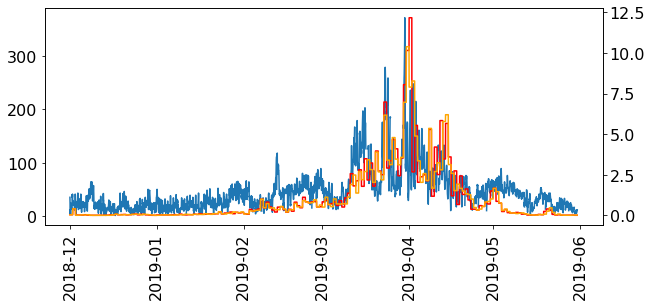

In [183]:
fire['arrival_time'] = cal_arrival_time(detection_time=fire.index,distance=fire['distance'],wind_speed=5)
temp = fire.set_index('arrival_time')
temp = temp.resample('d').sum()[['pow_damp']]

ax = plt.figure(figsize=(10,4)).gca()
start_time = '2018-12-01'
end_time = '2019-05-30'
ax.plot(aqm2_01.resample('h').mean().loc[start_time:end_time,'PM2.5'])

ax1 = ax.twinx()
#temp = temp.shift(24)
#temp = temp.rolling(24).sum()

#ax1.plot(temp.resample('h').sum().loc[start_time:end_time,'pow_damp'],color='orange')
ax1.plot(temp.resample('h').sum().rolling(24).sum().loc[start_time:end_time,'pow_damp'],color='red')

fire['arrival_time'] = cal_arrival_time(detection_time=fire.index,distance=fire['distance'],wind_speed=10)
temp = fire.set_index('arrival_time')
temp = temp.resample('d').sum()[['pow_damp']]
ax1.plot(temp.resample('h').sum().rolling(24).sum().loc[start_time:end_time,'pow_damp'],color='orange')

plt.setp(ax.get_xticklabels(), rotation=90);

In [119]:
fire['arrival_time'] = cal_arrival_time(detection_time=fire.index,distance=fire['distance'],wind_speed=5)
temp = fire.set_index('arrival_time')
temp = temp.resample('d').sum()[['pow_damp']]

ax = plt.figure(figsize=(10,4)).gca()
start_time = '2016-12-01'
end_time = '2017-05-30'
ax.plot(aqm2_01.resample('h').mean().loc[start_time:end_time,'PM2.5'])

ax1 = ax.twinx()
#temp = temp.shift(24)
#temp = temp.rolling(24).sum()

#ax1.plot(temp.resample('h').sum().loc[start_time:end_time,'pow_damp'],color='orange')
ax1.plot(temp.resample('h').sum().rolling(24).sum().loc[start_time:end_time,'pow_damp'],color='red')

fire['arrival_time'] = cal_arrival_time(detection_time=fire.index,distance=fire['distance'],wind_speed=10)
temp = fire.set_index('arrival_time')
temp = temp.resample('d').sum()[['pow_damp']]
ax1.plot(temp.resample('h').sum().rolling(24).sum().loc[start_time:end_time,'pow_damp'],color='orange')

plt.setp(ax.get_xticklabels(), rotation=90);

arrival_time
2002-07-06           NaN
2002-07-07           NaN
2002-07-08           NaN
2002-07-09           NaN
2002-07-10           NaN
                 ...    
2020-04-26    179.198709
2020-04-27    176.687872
2020-04-28    174.242768
2020-04-29    170.773183
2020-04-30    164.943524
Freq: D, Name: pow_damp, Length: 6509, dtype: float64

# Model PM2.5

In [26]:
cols = ['PM2.5', 'Temperature(C)', 'Humidity(%)', 'Wind', 'Wind Speed(kmph)']
pm25 = aqm2_01[cols].dropna()
# keep the data since '2011-05-07'
pm25 = pm25.loc['2010-01-01':] 

In [65]:
dummies = wind_to_dummies(pm25['Wind'])
pm25.drop('Wind',axis=1, inplace=True)
pm25 = pd.concat([pm25, dummies], axis=1)
pm25.head()

,PM2.5,Temperature(C),Humidity(%),Wind Speed(kmph),CALM,E,N,S,W
datetime,,,,,,,,,
2011-05-17 16:00:00,1.0,27.22,74.0,10.0,0,1,1,0,0
2011-05-17 17:00:00,1.0,25.00,83.0,10.0,0,1,0,0,0
2011-05-17 18:00:00,1.0,25.00,78.0,5.0,0,0,0,1,1
2011-05-17 19:00:00,1.0,25.00,83.0,3.0,0,0,0,1,1
2011-05-17 20:00:00,11.0,25.00,83.0,10.0,0,0,0,1,1
